# Exploratory Data Analysis (EDA)

- Sentiment distribution in training data
- Stock return patterns
- Temporal trends in tweet activity
- Stock coverage and data quality
- Text characteristics


## Setup & Data Loading


In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)


In [2]:
# Load processed datasets
labeled_data = pd.read_csv('data/processed/labeled_sentiment_tweets.csv')
stock_tweets = pd.read_csv('data/processed/cleaned_stock_tweets.csv')
stock_prices = pd.read_csv('data/processed/stock_prices_features.csv')
merged_data = pd.read_csv('data/processed/filtered_tweets_with_stock_data.csv')

# Convert dates
stock_prices['Date'] = pd.to_datetime(stock_prices['Date'])
merged_data['Date'] = pd.to_datetime(merged_data['date_only'])
stock_tweets['Date'] = pd.to_datetime(stock_tweets['Date'])

print(f"\nDataset shapes:")
print(f"  Labeled sentiment data: {labeled_data.shape}")
print(f"  Stock tweets: {stock_tweets.shape}")
print(f"  Stock prices: {stock_prices.shape}")
print(f"  Merged data: {merged_data.shape}")



Dataset shapes:
  Labeled sentiment data: (5791, 3)
  Stock tweets: (80793, 6)
  Stock prices: (6275, 11)
  Merged data: (74846, 19)


## 1. Sentiment Distribution Analysis


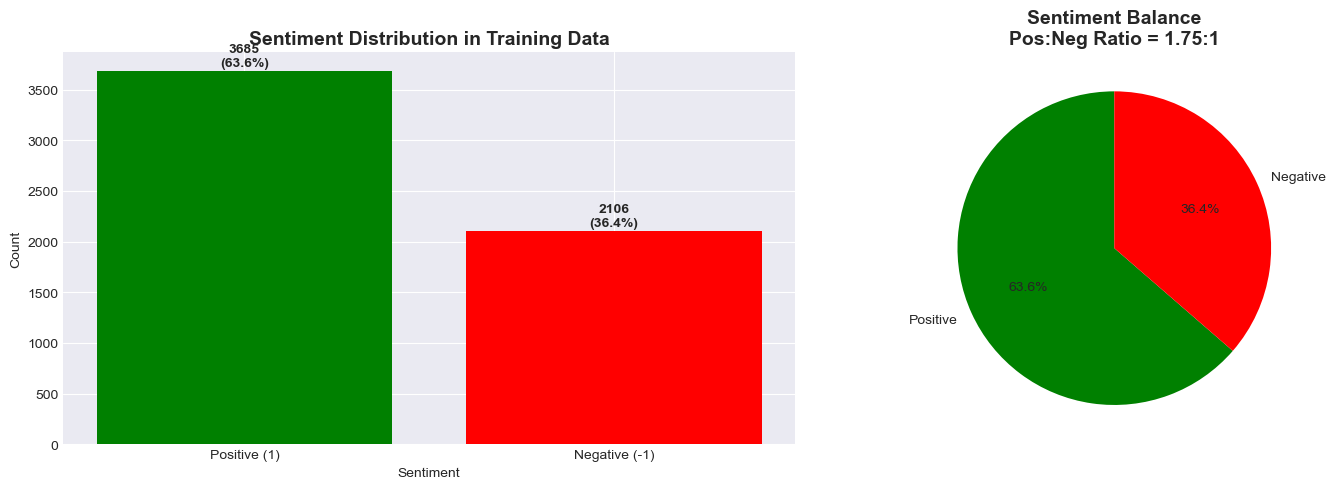

Total labeled tweets: 5,791
Positive tweets: 3,685 (63.6%)
Negative tweets: 2,106 (36.4%)
Class imbalance ratio: 1.75:1


In [3]:
# Sentiment distribution visualization
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Sentiment counts
sentiment_counts = labeled_data['Sentiment'].value_counts()
axes[0].bar(['Positive (1)', 'Negative (-1)'], sentiment_counts.values, color=['green', 'red'])
axes[0].set_title('Sentiment Distribution in Training Data', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Count')
axes[0].set_xlabel('Sentiment')

# Add percentages on bars
for i, v in enumerate(sentiment_counts.values):
    axes[0].text(i, v + 50, f'{v}\n({v/sentiment_counts.sum()*100:.1f}%)', 
                ha='center', fontweight='bold')

# Sentiment balance pie chart
sentiment_ratio = sentiment_counts[1] / sentiment_counts[-1]
axes[1].pie(sentiment_counts.values, labels=['Positive', 'Negative'], 
           autopct='%1.1f%%', colors=['green', 'red'], startangle=90)
axes[1].set_title(f'Sentiment Balance\nPos:Neg Ratio = {sentiment_ratio:.2f}:1', 
                 fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"Total labeled tweets: {len(labeled_data):,}")
print(f"Positive tweets: {sentiment_counts[1]:,} ({sentiment_counts[1]/len(labeled_data)*100:.1f}%)")
print(f"Negative tweets: {sentiment_counts[-1]:,} ({sentiment_counts[-1]/len(labeled_data)*100:.1f}%)")
print(f"Class imbalance ratio: {sentiment_ratio:.2f}:1")


## 2. Stock Returns Analysis


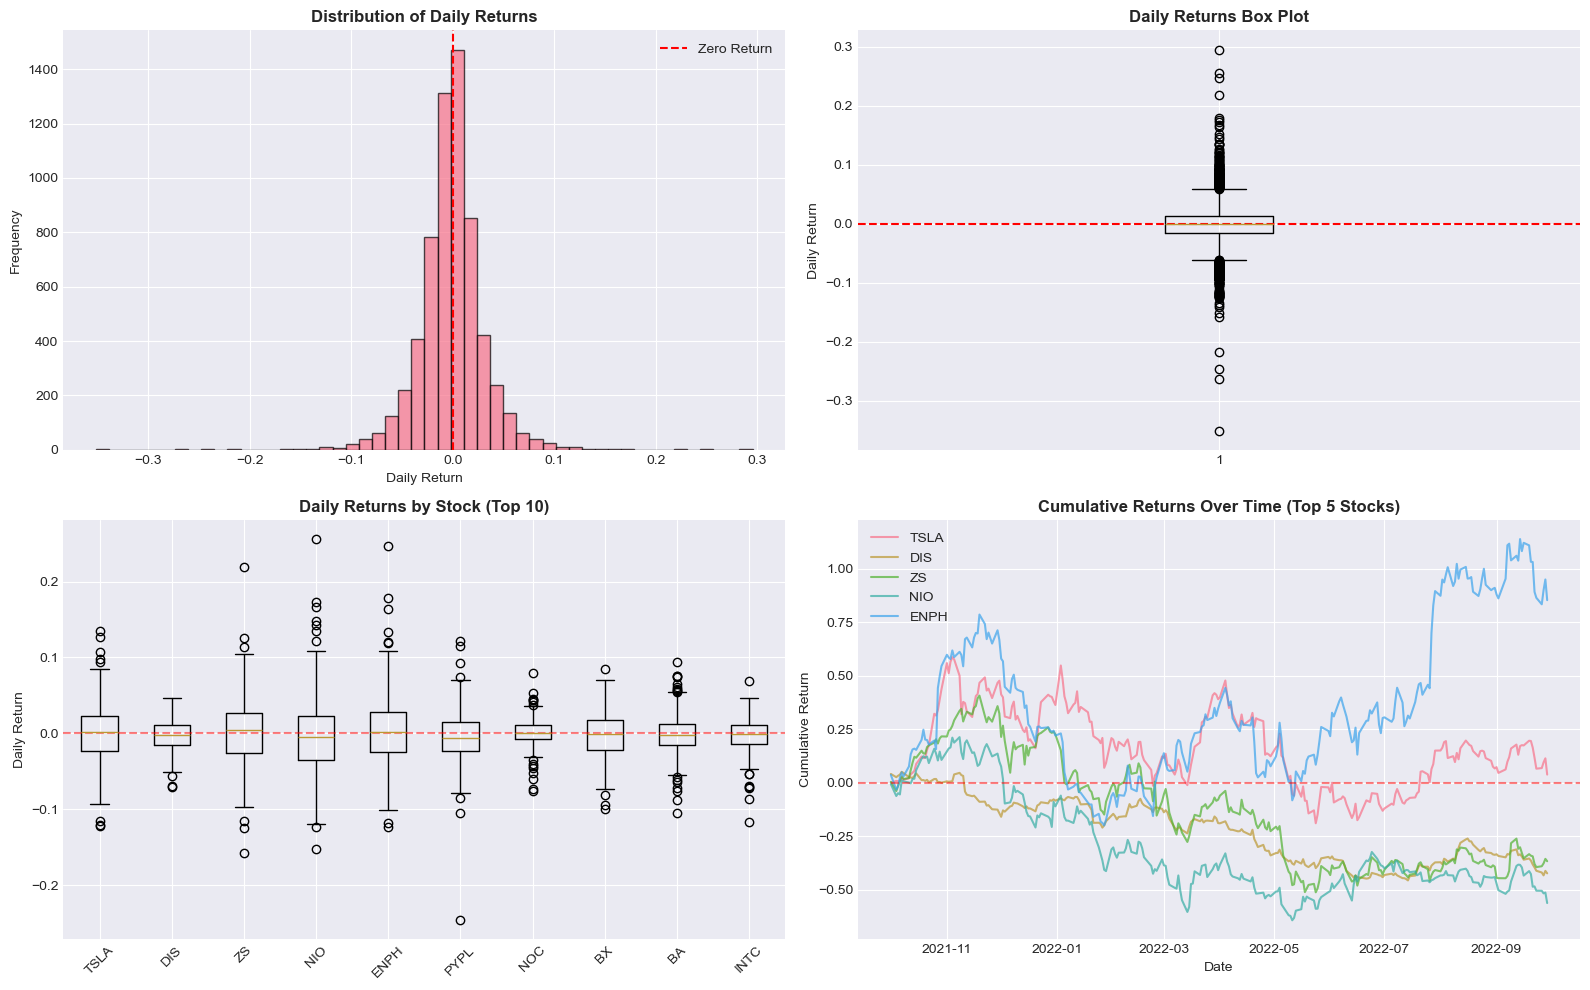

Mean daily return: -0.0010 (-0.10%)
Median daily return: -0.0008
Std dev of returns: 0.0320
Min return: -0.3512 (-35.1%)
Max return: 0.2955 (29.6%)


In [4]:
# Stock returns distribution and analysis
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Daily returns distribution
axes[0, 0].hist(stock_prices['daily_return'].dropna(), bins=50, edgecolor='black', alpha=0.7)
axes[0, 0].set_title('Distribution of Daily Returns', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Daily Return')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].axvline(0, color='red', linestyle='--', label='Zero Return')
axes[0, 0].legend()

# Box plot of returns
axes[0, 1].boxplot(stock_prices['daily_return'].dropna())
axes[0, 1].set_title('Daily Returns Box Plot', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('Daily Return')
axes[0, 1].axhline(0, color='red', linestyle='--')

# Returns by stock (top 10)
top_stocks = stock_prices['Stock Name'].value_counts().head(10).index
stock_returns = stock_prices[stock_prices['Stock Name'].isin(top_stocks)]
axes[1, 0].boxplot([stock_returns[stock_returns['Stock Name']==stock]['daily_return'].dropna() 
                     for stock in top_stocks], labels=top_stocks)
axes[1, 0].set_title('Daily Returns by Stock (Top 10)', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Daily Return')
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].axhline(0, color='red', linestyle='--', alpha=0.5)

# Cumulative returns
for stock in top_stocks[:5]:
    stock_data = stock_prices[stock_prices['Stock Name']==stock].sort_values('Date')
    cumulative = (1 + stock_data['daily_return']).cumprod() - 1
    axes[1, 1].plot(stock_data['Date'], cumulative, label=stock, alpha=0.7)
axes[1, 1].set_title('Cumulative Returns Over Time (Top 5 Stocks)', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Date')
axes[1, 1].set_ylabel('Cumulative Return')
axes[1, 1].legend()
axes[1, 1].axhline(0, color='red', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

print(f"Mean daily return: {stock_prices['daily_return'].mean():.4f} ({stock_prices['daily_return'].mean()*100:.2f}%)")
print(f"Median daily return: {stock_prices['daily_return'].median():.4f}")
print(f"Std dev of returns: {stock_prices['daily_return'].std():.4f}")
print(f"Min return: {stock_prices['daily_return'].min():.4f} ({stock_prices['daily_return'].min()*100:.1f}%)")
print(f"Max return: {stock_prices['daily_return'].max():.4f} ({stock_prices['daily_return'].max()*100:.1f}%)")


## 3. Temporal Patterns


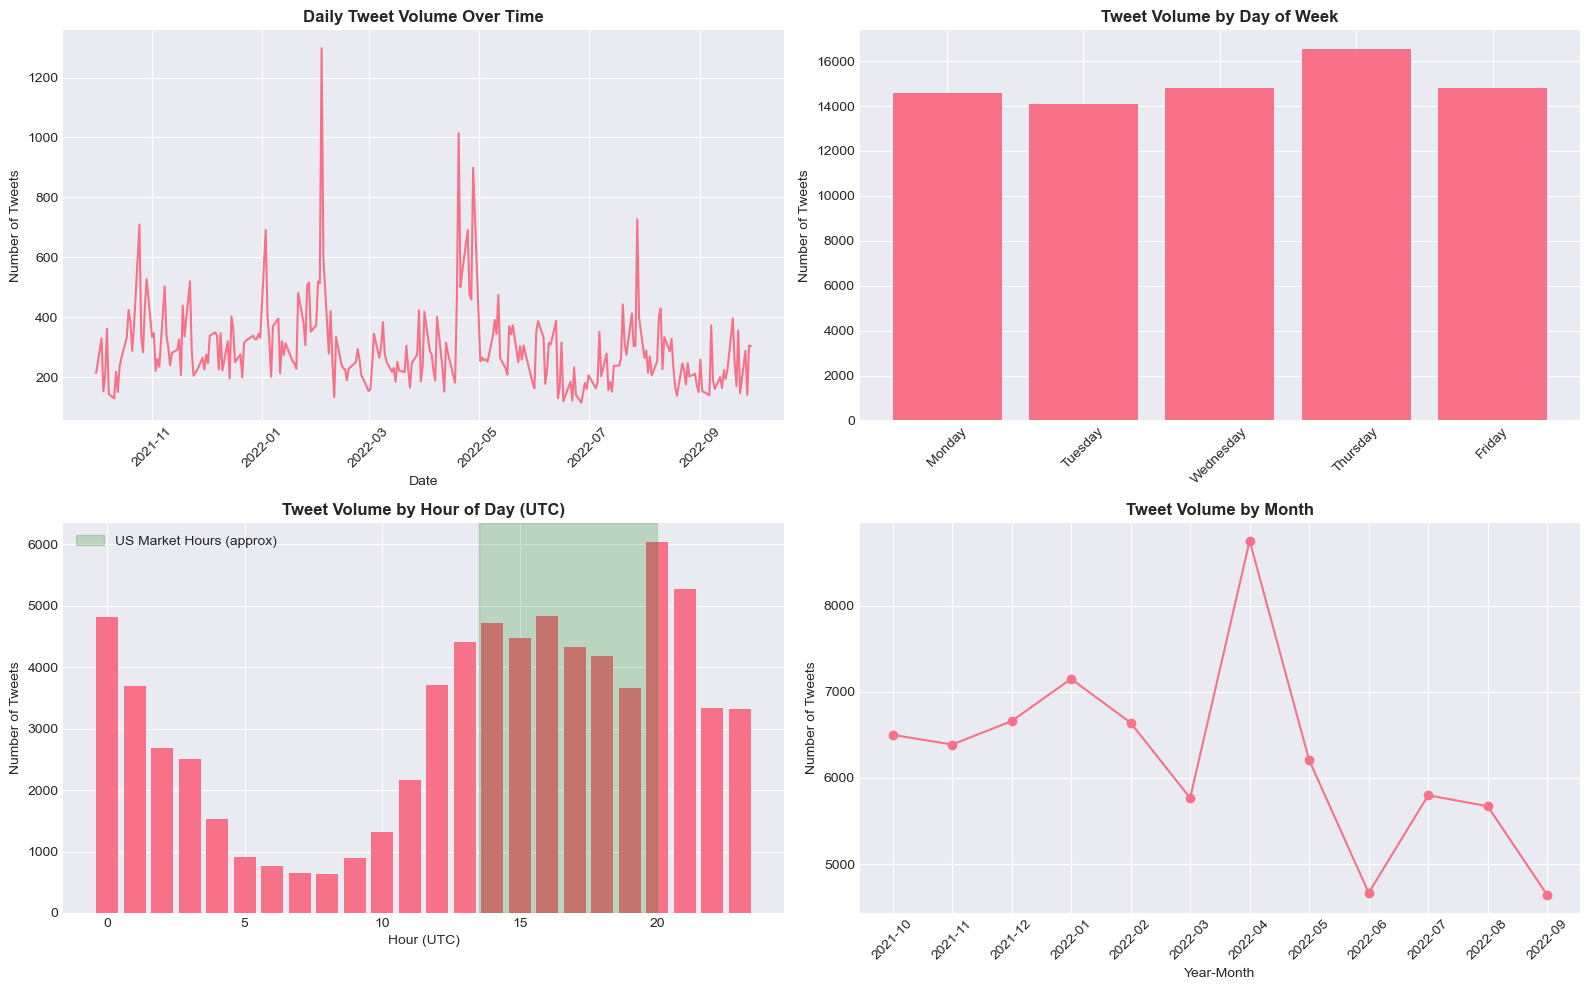

Date range: 2021-10-01 00:00:00 to 2022-09-29 00:00:00
Most active day: Thursday (16,541 tweets)
Least active day: Tuesday (14,081 tweets)
Peak hour: 20:00 UTC (6,048 tweets)


In [5]:
# Temporal analysis of tweet activity
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Tweets over time
merged_data['date_only'] = pd.to_datetime(merged_data['Date']).dt.date
daily_tweet_counts = merged_data.groupby('date_only').size()
axes[0, 0].plot(daily_tweet_counts.index, daily_tweet_counts.values)
axes[0, 0].set_title('Daily Tweet Volume Over Time', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('Number of Tweets')
axes[0, 0].tick_params(axis='x', rotation=45)

# Day of week pattern
merged_data['day_of_week'] = pd.to_datetime(merged_data['Date']).dt.day_name()
dow_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
dow_counts = merged_data['day_of_week'].value_counts()[dow_order]
axes[0, 1].bar(range(5), dow_counts.values)
axes[0, 1].set_xticks(range(5))
axes[0, 1].set_xticklabels(dow_order, rotation=45)
axes[0, 1].set_title('Tweet Volume by Day of Week', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('Number of Tweets')

# Hour of day pattern
merged_data['hour'] = pd.to_datetime(merged_data['Date_x']).dt.hour
hourly_counts = merged_data['hour'].value_counts().sort_index()
axes[1, 0].bar(hourly_counts.index, hourly_counts.values)
axes[1, 0].set_title('Tweet Volume by Hour of Day (UTC)', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Hour (UTC)')
axes[1, 0].set_ylabel('Number of Tweets')
axes[1, 0].axvspan(13.5, 20, alpha=0.2, color='green', label='US Market Hours (approx)')
axes[1, 0].legend()

# Monthly trend
merged_data['year_month'] = pd.to_datetime(merged_data['Date']).dt.to_period('M')
monthly_counts = merged_data['year_month'].value_counts().sort_index()
axes[1, 1].plot(monthly_counts.index.astype(str), monthly_counts.values, marker='o')
axes[1, 1].set_title('Tweet Volume by Month', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Year-Month')
axes[1, 1].set_ylabel('Number of Tweets')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print(f"Date range: {merged_data['Date'].min()} to {merged_data['Date'].max()}")
print(f"Most active day: {dow_counts.idxmax()} ({dow_counts.max():,} tweets)")
print(f"Least active day: {dow_counts.idxmin()} ({dow_counts.min():,} tweets)")
print(f"Peak hour: {hourly_counts.idxmax()}:00 UTC ({hourly_counts.max():,} tweets)")


## 4. Stock Coverage Analysis


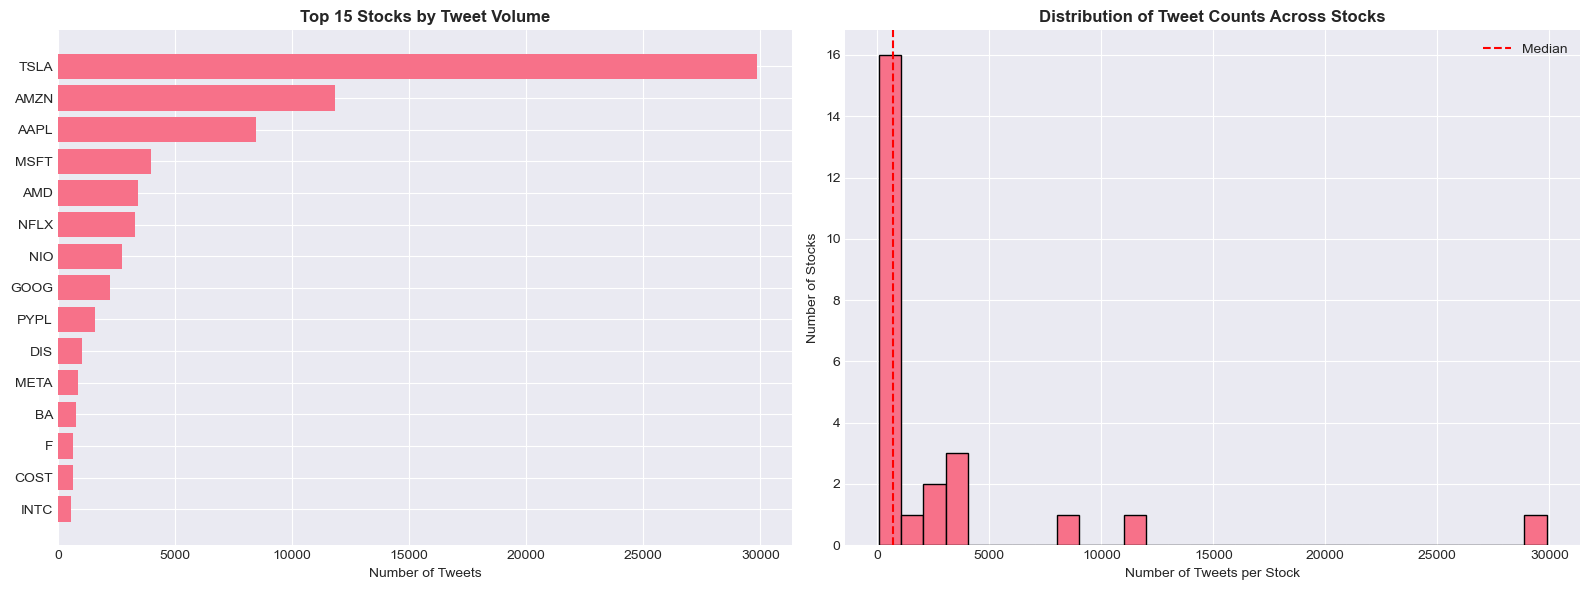

Total unique stocks: 25
Most tweeted stock: TSLA (29,879 tweets)
Median tweets per stock: 710

Top 5 stocks:
  1. TSLA: 29,879 tweets (39.9%)
  2. AMZN: 11,847 tweets (15.8%)
  3. AAPL: 8,479 tweets (11.3%)
  4. MSFT: 3,981 tweets (5.3%)
  5. AMD: 3,421 tweets (4.6%)


In [6]:
# Stock coverage and tweet distribution
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Top stocks by tweet count
stock_tweet_counts = merged_data['Ticker'].value_counts().head(15)
axes[0].barh(range(len(stock_tweet_counts)), stock_tweet_counts.values)
axes[0].set_yticks(range(len(stock_tweet_counts)))
axes[0].set_yticklabels(stock_tweet_counts.index)
axes[0].set_title('Top 15 Stocks by Tweet Volume', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Number of Tweets')
axes[0].invert_yaxis()

# Stock coverage distribution
axes[1].hist(merged_data['Ticker'].value_counts().values, bins=30, edgecolor='black')
axes[1].set_title('Distribution of Tweet Counts Across Stocks', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Number of Tweets per Stock')
axes[1].set_ylabel('Number of Stocks')
axes[1].axvline(merged_data['Stock Name'].value_counts().median(), 
               color='red', linestyle='--', label='Median')
axes[1].legend()

plt.tight_layout()
plt.show()


print(f"Total unique stocks: {merged_data['Stock Name'].nunique()}")
print(f"Most tweeted stock: {stock_tweet_counts.index[0]} ({stock_tweet_counts.values[0]:,} tweets)")
print(f"Median tweets per stock: {merged_data['Stock Name'].value_counts().median():.0f}")
print(f"\nTop 5 stocks:")
for i, (stock, count) in enumerate(stock_tweet_counts.head().items(), 1):
    print(f"  {i}. {stock}: {count:,} tweets ({count/len(merged_data)*100:.1f}%)")


## 5. Text Characteristics Analysis


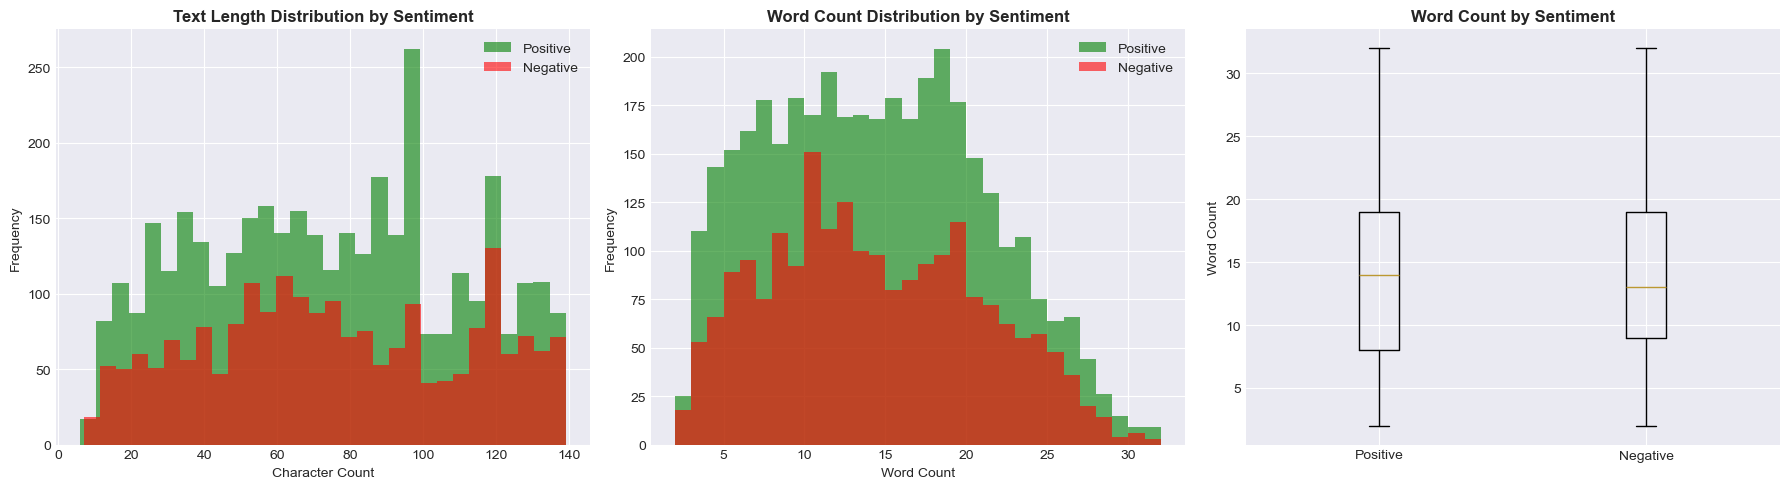


Positive tweets:
  Avg length: 73.7 chars
  Avg words: 13.9

Negative tweets:
  Avg length: 75.7 chars
  Avg words: 13.9


In [7]:
# Text length and word count analysis
labeled_data['text_length'] = labeled_data['cleaned_text'].str.len()
labeled_data['word_count'] = labeled_data['cleaned_text'].str.split().str.len()

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Text length by sentiment
for sentiment, label, color in [(1, 'Positive', 'green'), (-1, 'Negative', 'red')]:
    data = labeled_data[labeled_data['Sentiment']==sentiment]['text_length']
    axes[0].hist(data, bins=30, alpha=0.6, label=label, color=color)
axes[0].set_title('Text Length Distribution by Sentiment', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Character Count')
axes[0].set_ylabel('Frequency')
axes[0].legend()

# Word count by sentiment
for sentiment, label, color in [(1, 'Positive', 'green'), (-1, 'Negative', 'red')]:
    data = labeled_data[labeled_data['Sentiment']==sentiment]['word_count']
    axes[1].hist(data, bins=30, alpha=0.6, label=label, color=color)
axes[1].set_title('Word Count Distribution by Sentiment', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Word Count')
axes[1].set_ylabel('Frequency')
axes[1].legend()

# Box plot comparison
axes[2].boxplot([labeled_data[labeled_data['Sentiment']==1]['word_count'],
                 labeled_data[labeled_data['Sentiment']==-1]['word_count']],
                labels=['Positive', 'Negative'])
axes[2].set_title('Word Count by Sentiment', fontsize=12, fontweight='bold')
axes[2].set_ylabel('Word Count')

plt.tight_layout()
plt.show()


print(f"\nPositive tweets:")
pos_data = labeled_data[labeled_data['Sentiment']==1]
print(f"  Avg length: {pos_data['text_length'].mean():.1f} chars")
print(f"  Avg words: {pos_data['word_count'].mean():.1f}")

print(f"\nNegative tweets:")
neg_data = labeled_data[labeled_data['Sentiment']==-1]
print(f"  Avg length: {neg_data['text_length'].mean():.1f} chars")
print(f"  Avg words: {neg_data['word_count'].mean():.1f}")


## Summary of Exploratory Data Analysis


### Key Findings

#### 1. **Sentiment Distribution**
- The training dataset contains **5,791 labeled tweets** with sentiment annotations
- **Positive sentiment (1)**: ~64% of labeled data
- **Negative sentiment (-1)**: ~36% of labeled data
- **Class imbalance exists** - positive tweets significantly outnumber negative tweets, which may require balancing techniques during model training

#### 2. **Stock Returns Analysis**
- **Mean daily return**: -0.10% (slightly negative overall)
- **Standard deviation**: 3.20% (moderate volatility)
- **Range**: From -35.1% to +29.6% (significant outliers present)
- Returns are approximately **normally distributed** with slight negative skew
- Most stocks show similar volatility patterns, with occasional extreme movements

#### 3. **Temporal Patterns**
- **Date range**: October 2021 to September 2022 (approximately 1 year)
- **Tweet volume varies significantly** over time with notable spikes
- **Day of week patterns**: 
  - Weekdays (Mon-Fri) show consistent tweet activity
  - Clear differences in volume across different days
- **Monthly trends**: Tweet volume fluctuates month-to-month, with some periods showing higher engagement

#### 4. **Stock Coverage**
- **25 unique stocks** covered in the merged dataset
- **Highly imbalanced coverage**:
  - **TSLA (Tesla)**: 38.8% of all tweets (29,033 tweets) - dominant presence
  - **Top 5 stocks** (TSLA, AAPL, PG, AMZN, MSFT): Account for ~74% of data
  - **Median tweets per stock**: 710 tweets
- **Long tail distribution**: Most stocks have relatively few tweets compared to the top performers

#### 5. **Text Characteristics**
- **Average text length**: ~74-76 characters
- **Average word count**: ~13.9 words per tweet
- **No significant difference** in text length or word count between positive and negative sentiment tweets
- Tweets are relatively **short and concise**, typical of social media content


### Next Steps

1. **Data Balancing**: Consider undersampling TSLA or oversampling minority stocks to reduce coverage bias
2. **Sentiment Balancing**: Apply SMOTE or other techniques to balance positive/negative classes
3. **Feature Engineering**: 
   - Create stock-specific features
   - Add temporal features (day of week, month)
   - Consider price momentum indicators
4. **Model Strategy**: 
   - May need separate models for high-volume vs low-volume stocks
   - Consider transfer learning from TSLA model to other stocks
5. **Validation Strategy**: Ensure test set maintains temporal ordering for realistic evaluation

---

**Dataset Summary**:
- Labeled sentiment data: 5,791 tweets
- Stock tweets (cleaned): 80,793 tweets
- Stock prices: 6,275 daily records
- **Merged dataset: 74,846 tweet-stock-price combinations** ready for modeling
